In [2]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt

In [3]:
nside = 256

In [4]:
# a) Read and apodize mask
mask_path = "/home/ketchup/tools/NaMaster/test/"
mask = nmt.mask_apodization(hp.read_map(mask_path + "mask.fits", verbose=False),
                            1., apotype="Smooth")

In [5]:
# Let's now create a fictitious theoretical power spectrum to generate
# Gaussian realizations:
larr = np.arange(3*nside)
clarr = ((larr+1.)/80.)**(-1.1)+1.

In [6]:
cl_tt = clarr
cl_ee = clarr
cl_bb = 0*clarr
cl_te = 0*clarr
cl_tb = 0*clarr
cl_eb = 0*clarr

In [32]:
G_ps_path = "/home/ketchup/DES_ACT/inputgabriela/"

ellmin = 10
ellmax = 1000


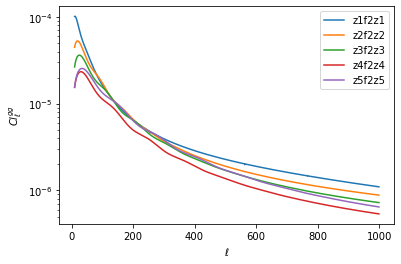

In [56]:
# plot galaxy x galaxy ps in the same redshift bins, linear galaxy scale
maps = ['gg']
zs_bins = ['z1f2z1', 'z2f2z2', 'z3f2z3', 'z4f2z4', 'z5f2z5']
for map in maps:
    for zs_bin in zs_bins:
        Cl_name = 'Cl'+'gg'+'_input_'+'%s.dat' %zs_bin
        # print(Cl_name)
        Cl = np.loadtxt(G_ps_path + Cl_name)
        plt.plot(Cl[ellmin:ellmax,0], Cl[ellmin:ellmax,1], label=zs_bin)
plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$Cl^{gg}_{\ell}$')
plt.yscale('log')